# InClass exercises, 11152021 (randomization and bootstrapping)


## First start by importing the packages you'll need. 
* Numpy, scipy, and matplotlib


In [1]:
import numpy as np
from scipy import stats  # has t-tests and other stats stuff...
import matplotlib.pyplot as plt

## Part I: Start with some data. This is another (slightly modified) part of the Anscombe data set
* First plot it
* Then compute the correlation coeffecient that relates the two arrays
* Then the t-value and p-value associated with the correlation. 

In [2]:
d1 = np.array([8, 8, 8, 8, 8, 8, 8, 12.5, 8, 8, 8])
d2 = np.array([6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 19, 5.56, 7.91, 6.89])

## Ok - now plot the data

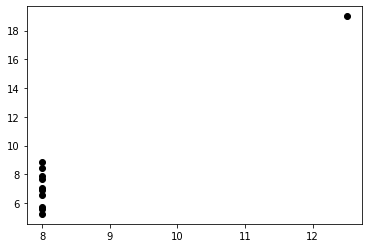

In [4]:
plt.scatter(d1, d2, color = 'k')
plt.show()

## Based on this plot, what do you think is going to happen when we compare the output from a parametric test and a radomization test?
* Compute parametric correlation coef and p-value and then do randomization testing

In [15]:
N = len(d1)
para_r, para_p, = stats.pearsonr(d1, d2)
print(para_r)
print(para_p)
#t_stats = stats.ttest_1samp(d1-d2, 0)


0.9513052040435971
6.769043482081971e-06


## Now use randomization testing to put a better p-value on the data...

In [23]:
num_rands = 10000
np.random.seed(0)
null_r = np.zeros(num_rands)

tmp0 = np.zeros(N)
tmp1 = np.zeros(N)

for i in np.arange(num_rands): 
    for j in np.arange(N): 
        if np.random.rand() < .5:
            tmp0[j] = d1[j]
            tmp1[j] = d2[j]
        else: 
            tmp0[j] = d2[j]
            tmp1[j] = d1[j]
            
    null_r[i], _= stats.pearsonr(tmp0, tmp1)

null_p = 2 * (np.sum(null_r>para_r)/num_rands)

print(null_p)

0.0138


## Part II: Load in some of the EEG data 
* Pull out the data, sr, and tx arrays

In [24]:
# load the data...
eeg = np.load('eeg_data01.npz')

# get the different arrays like this...kind of like a structure in matlab. 
eeg['data']
eeg['sr']
eeg['tx']

# and can query the attributes of the data like this...which will tell us that there 1600 trials and 4102 timepoints per trial sampled
# at 1024Hz
print('Shape of the big eeg data set: ', eeg['data'].shape)
print('Sample rate: ', eeg['sr'])

# and if you want to save some typing, especially because we only have a few variables, you reassign the different arrays like this
data = eeg['data']
sr = eeg['sr']
tx = eeg['tx']

Shape of the big eeg data set:  (1600, 4102)
Sample rate:  1024


## Below is a vector that labels each trial as coming from experimental conditions 1,2,3,4

In [25]:
N = data.shape[0]
num_samp_cond = int(N/4)
cond = np.hstack((np.ones(num_samp_cond), np.ones(num_samp_cond)*2, np.ones(num_samp_cond)*3, np.ones(num_samp_cond)*4))

## Now avgerage the data from condition 2, avg the data from condition 3, and plot against the time axis (tx) - we're going to ignore conditions 1 and 4

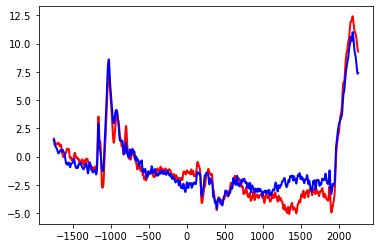

In [35]:
cond2_mean = np.mean(data[cond == 2,:], axis = 0)
cond3_mean = np.mean(data[cond == 3,:], axis = 0)

plt.plot(tx, cond2_mean, color='r', linewidth=2)
plt.plot(tx, cond3_mean, color='b', linewidth=2)
plt.show()

## Now put confidence intervals on the data using bootstrapping
* To do this, you might first create two 800 x 4102 matrices, one with data from all trials of condition 2, and one with data from all trials of condition 3
* Then resample 800 trials, with replacement, from each data matrix and then do the t-test. 
* try generating a set of 800 values with repeating numbers that you can use for a row index into the data matrices
* repeat and then compute CIs of the t-value
* how often do the CIs for the t-value overlap with 0???
* note - this can take a while, so start with 50 bootstraps and then increase as compute time allows

In [61]:
d1 = data[cond==2,:]
d2 = data[cond==3,:]

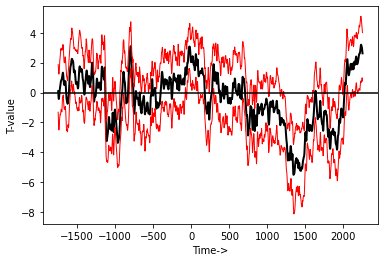

In [62]:
num_samp_cond = d1.shape[0]
num_boots = 50
boot_means = np.zeros((num_boots, data.shape[1]))

for i in np.arange(num_boots): 
    idx = np.random.randint(num_samp_cond, size = num_samp_cond)
    tmp1 = d1[idx,:]
    tmp2 = d2[idx,:]
    tmp_t_stats = stats.ttest_1samp(tmp1 - tmp2, 0, axis=0)   
    boot_means[i,:] = tmp_t_stats.statistic


CIs = np.percentile(boot_means, [2.5, 97.5], axis = 0)

plt.plot(tx, np.mean((boot_means), axis=0), color='k', linewidth=2)
plt.plot(tx, CIs[0,], color='r', linewidth=1)
plt.plot(tx, CIs[1,], color='r', linewidth=1)
plt.axhline(0, color='k')
plt.xlabel('Time->')
plt.ylabel('T-value')
plt.show()

In [57]:
boot_means.shape

(50, 4102)